In [2]:
# !git clone https://github.com/dmc27/missing_pixels.git

In [1]:
import cv2 as cv
import numpy as np
from tqdm import tqdm
from os import listdir
from os.path import isfile, join
from sklearn.metrics import accuracy_score

# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import load_model
# from tensorflow.keras.callbacks import ModelCheckpoint
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms as T
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR


from utils.utils import *
from utils.database import MissingPixelDataset
from model.architecture import *


import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.dpi"] = 120

from IPython.display import HTML
shell = get_ipython()

def adjust_font_size():
  display(HTML('''<style>
    body {
      font-size: 16px;
    }
  '''))

if adjust_font_size not in shell.events.callbacks['pre_execute']:
  shell.events.register('pre_execute', adjust_font_size)



BLOCK_SIZE = 8
BATCH_SIZE = 1024
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
# WEIGHT_DECAY = 0.05
STEPLR_GAMMA = 0.5
RUN_UTILITY = False

IMG_TEST_PATH = './dataset/original_image/'
IMG_TRAINING_PATH = './dataset/training_image/train/'
IMG_SAVE_PATH = './dataset/missing_pixel/'
TRAINED_MODEL_PATH = './trained_model/convmodel1_bn_trainsize_10k_batchsize_1024_1.pth'

listof_test_image = next(os.walk(IMG_TEST_PATH), (None, None, []))[2]
test_img_name = 'balloon.bmp'

In [2]:
if RUN_UTILITY:
    create_dataset_autoencoder(IMG_PATH, IMG_SAVE_PATH, BLOCK_SIZE, img_size=(256, 256))

In [3]:
# Calling PrepareDataset class in the utilities for preparing the dataset for training,
# X is the input to the network architecture, and y is the target output of the network
data = PrepareDataset(IMG_TRAINING_PATH, IMG_TEST_PATH, IMG_SAVE_PATH, block_size=BLOCK_SIZE)
X, y = data.create_dataset_2d(sample_size = 10000)
X_test, y_test = data.create_test_2d()


# Creating dataset for the pytorch model (converted to tensor)
train_dataset = MissingPixelDataset(X, y, scaling=False)
test_dataset = MissingPixelDataset(X_test, y_test, scaling=False)


# Create training dataloader to make a batch learning for the pytorch model
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=0, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=0, batch_size=BATCH_SIZE)

TypeError: PrepareDataset.__init__() got multiple values for argument 'block_size'

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [5]:
model = ConvModel1().double().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = StepLR(optimizer, step_size=5, gamma=STEPLR_GAMMA)

In [6]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    
    train_loss = 0
    pbar = tqdm(train_loader)
    for batch_idx, (X_train, y_train) in enumerate(pbar):
        X_train, y_train = X_train.to(device), y_train.to(device)
        
        output = model(X_train.unsqueeze(1))
        
        loss = criterion(output, y_train)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
        
        pbar.set_description(desc= f'Epoch {epoch} loss={loss.item()} batch_id={batch_idx}')
    
    train_loss /= len(train_loader.dataset)

    print('Train set: Average loss: {:.32f}'.format(train_loss))

In [7]:
def test(model, device, test_loader, criterion):

    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to keep track of the loss and accuracy
    test_loss = 0

    # Use tqdm to display the progress of the testing loop
    pbar = tqdm(test_loader)
    with torch.no_grad():
        for batch_idx, (test_X, test_y) in enumerate(pbar):
            test_X, test_y = test_X.to(device), test_y.to(device)
            
            output = model(test_X.unsqueeze(1))
            
            loss = criterion(output, test_y)
            test_loss += loss.item()

    
    test_loss /= len(test_loader.dataset)

    # Print the results
    print('Test set: Average loss: {:.32f}'.format(test_loss))
    print()
    return test_loss

In [8]:
best_loss = 9999.
for epoch in range(1, NUM_EPOCHS + 1):
    train(model, device, train_dataloader, optimizer, criterion, epoch)
    test_loss = test(model, device, test_dataloader, criterion)
    if best_loss > test_loss:
        torch.save(model.state_dict(), TRAINED_MODEL_PATH)
        best_loss = test_loss
    # plot_loss()
    # test(model, device, test_dataloader, criterion)
    scheduler.step()

Epoch 1 loss=0.0018185577954870525 batch_id=9999: 100%|██████████| 10000/10000 [09:00<00:00, 18.50it/s]


Train set: Average loss: 0.00000175246280675910068174198301


100%|██████████| 55/55 [00:00<00:00, 56.56it/s]


Test set: Average loss: 0.00000253795264781853066422758099



Epoch 2 loss=0.0014168686995759854 batch_id=9999: 100%|██████████| 10000/10000 [09:02<00:00, 18.43it/s]


Train set: Average loss: 0.00000154168265562218685455679688


100%|██████████| 55/55 [00:00<00:00, 56.36it/s]


Test set: Average loss: 0.00000239100809948672663189823961



Epoch 3 loss=0.001724717420612086 batch_id=9999: 100%|██████████| 10000/10000 [09:16<00:00, 17.95it/s]


Train set: Average loss: 0.00000148750785123453108501007450


100%|██████████| 55/55 [00:01<00:00, 53.47it/s]


Test set: Average loss: 0.00000254135213608035711078080021



Epoch 4 loss=0.0014163269851804883 batch_id=9999: 100%|██████████| 10000/10000 [09:23<00:00, 17.75it/s]


Train set: Average loss: 0.00000145980670204580536590478930


100%|██████████| 55/55 [00:01<00:00, 54.54it/s]


Test set: Average loss: 0.00000219779497961796310142668434



Epoch 5 loss=0.0010909794716971784 batch_id=9999: 100%|██████████| 10000/10000 [09:15<00:00, 18.01it/s]


Train set: Average loss: 0.00000143410978724407613386253920


100%|██████████| 55/55 [00:00<00:00, 56.19it/s]


Test set: Average loss: 0.00000222827933917939440810747180



Epoch 6 loss=0.0013197605761545018 batch_id=9999: 100%|██████████| 10000/10000 [09:05<00:00, 18.34it/s]


Train set: Average loss: 0.00000137363450321328435367140668


100%|██████████| 55/55 [00:00<00:00, 57.02it/s]


Test set: Average loss: 0.00000216859884783329749026350823



Epoch 7 loss=0.001656832679917486 batch_id=9999: 100%|██████████| 10000/10000 [08:46<00:00, 19.00it/s]


Train set: Average loss: 0.00000135720298020525949604826732


100%|██████████| 55/55 [00:00<00:00, 56.85it/s]


Test set: Average loss: 0.00000218735443528872346521420289



Epoch 8 loss=0.0012462489532123805 batch_id=9999: 100%|██████████| 10000/10000 [08:44<00:00, 19.06it/s]


Train set: Average loss: 0.00000134425516559243313917295769


100%|██████████| 55/55 [00:00<00:00, 57.02it/s]


Test set: Average loss: 0.00000217771118055364003301835676



Epoch 9 loss=0.0011328293778586187 batch_id=9999: 100%|██████████| 10000/10000 [08:41<00:00, 19.17it/s]


Train set: Average loss: 0.00000133432524213779866474605118


100%|██████████| 55/55 [00:00<00:00, 56.09it/s]


Test set: Average loss: 0.00000220758200128011430323914273



Epoch 10 loss=0.0015215371332227843 batch_id=9999: 100%|██████████| 10000/10000 [09:13<00:00, 18.06it/s]


Train set: Average loss: 0.00000132324203240305691716522610


100%|██████████| 55/55 [00:00<00:00, 56.87it/s]


Test set: Average loss: 0.00000219692362564312514619101376



Epoch 11 loss=0.001278357410834556 batch_id=9999: 100%|██████████| 10000/10000 [09:13<00:00, 18.08it/s]


Train set: Average loss: 0.00000129191270642198525123850710


100%|██████████| 55/55 [00:00<00:00, 55.89it/s]


Test set: Average loss: 0.00000221090624742918628143706697



Epoch 12 loss=0.0014181165827690813 batch_id=9999: 100%|██████████| 10000/10000 [08:51<00:00, 18.83it/s]


Train set: Average loss: 0.00000128416193548319016702618806


100%|██████████| 55/55 [00:00<00:00, 55.94it/s]


Test set: Average loss: 0.00000220867290783069643536509589



Epoch 13 loss=0.0014410065574367885 batch_id=9999: 100%|██████████| 10000/10000 [08:31<00:00, 19.53it/s]


Train set: Average loss: 0.00000127616046761462787238012792


100%|██████████| 55/55 [00:00<00:00, 59.73it/s]


Test set: Average loss: 0.00000222340475300809842958680608



Epoch 14 loss=0.0012710710919162167 batch_id=9999: 100%|██████████| 10000/10000 [08:28<00:00, 19.65it/s]


Train set: Average loss: 0.00000126925056559265328121380821


100%|██████████| 55/55 [00:01<00:00, 53.68it/s]


Test set: Average loss: 0.00000223288286864321558610889558



Epoch 15 loss=0.0012419862048666996 batch_id=564:   6%|▌         | 564/10000 [00:32<09:07, 17.22it/s]


KeyboardInterrupt: 

In [9]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH))

<All keys matched successfully>

In [11]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def calculate_model_loss_2d(test_img_path):
    model.eval()
    mse = []
    psnr = []
    for test_path in test_img_path:
        image = data._preprocess_image('./dataset/original_image/' + test_path)
        tiled_image = data._reshape_split(image)
        X_test = tiled_image.copy()
        X_test[:, 3:5, 3:5] = np.array([[0., 0.],
                                    [0., 0.]])
        test = X_test / 255.
        prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device).unsqueeze(1)).detach().cpu().numpy()
        prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
        X_test[:, 3:5, 3:5] = prediction_result
        pred = X_test.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)
        err = pred - image
        mse.append((err**2).mean())
        psnr.append(PSNR(pred, image))
    return mse, psnr

def calculate_model_loss_original(test_img_path):
    model.eval()
    mse = []
    psnr = []
    for test_path in test_img_path:
        image = data._preprocess_image('./dataset/original_image/' + test_path)
        tiled_image = data._reshape_split(image)
        X_test = tiled_image.copy()
        X_test[:, 3:5, 3:5] = np.array([[0., 0.],
                                    [0., 0.]])
        test = X_test[~np.isnan(X_test)].reshape(-1, 60) / 255.
        prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device).unsqueeze(1)).detach().cpu().numpy()
        prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
        X_test[:, 3:5, 3:5] = prediction_result
        pred = X_test.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)
        err = pred - image
        mse.append((err**2).mean())
        psnr.append(PSNR(pred, image))
    return mse, psnr

def test_model_2d(img_name):
    model.eval()
    image = data._preprocess_image('./dataset/original_image/' + img_name)
    tiled_image = data._reshape_split(image)
    X_test = tiled_image.copy()
    X_test[:, 3:5, 3:5] = np.array([[0., 0.],
                                [0., 0.]])
    test = X_test / 255.
    prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device).unsqueeze(1)).detach().cpu().numpy()
    prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
    X_test[:, 3:5, 3:5] = prediction_result
    pred = X_test.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)
    return pred

def test_model_original(img_name):
    model.eval()
    image = data._preprocess_image('./dataset/original_image/' + img_name)
    tiled_image = data._reshape_split(image)
    X_test = tiled_image.copy()
    X_test[:, 3:5, 3:5] = np.array([[None, None],
                                [None, None]])
    test = X_test[~np.isnan(X_test)].reshape(-1, 60) / 255.
    prediction_result = model(torch.tensor(test, dtype=torch.float64).to(device)).detach().cpu().numpy()
    prediction_result = prediction_result.reshape(-1, 2, 2) * 255.
    X_test[:, 3:5, 3:5] = prediction_result
    pred = X_test.reshape(32, 32, 8, 8).swapaxes(1, 2).reshape(256, 256)


In [12]:
mse, psnr = calculate_model_loss_2d(listof_test_image)
pred = test_model_2d(test_img_name)
print(np.mean(mse))
print(np.mean(psnr))

9.024840965143055
41.11263530337968


MSE = 7.27


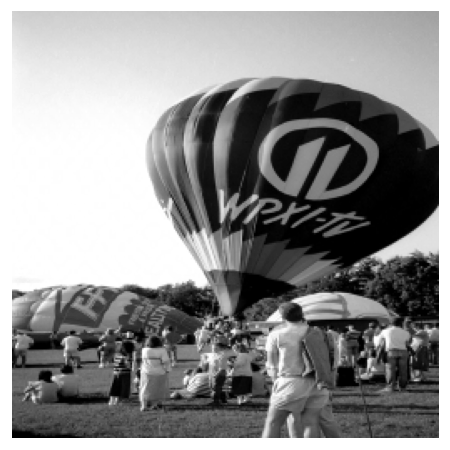

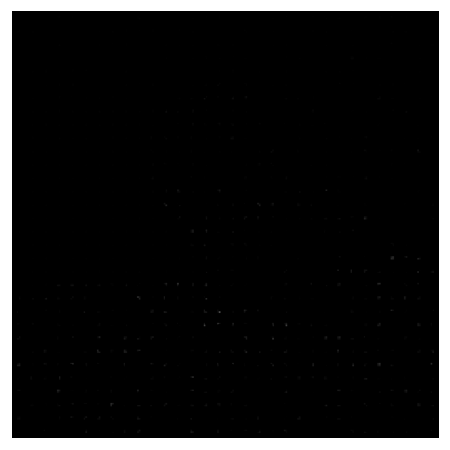

In [14]:
img = cv.imread(join(IMG_TEST_PATH, 'balloon.bmp'), cv.IMREAD_GRAYSCALE)
img = cv.resize(img, (256, 256), cv.INTER_CUBIC)
img = img.astype(np.float64)

# compute the MSE between the original and reconstructed images
err = pred - img
print("MSE =", "{:.2f}".format((err**2).mean()))

imshow(pred, "gray", dpi=72)
imshow(pred - img, 'gray', dpi = 72)
